In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def sine(x, A, lam, ph):
    #simple sine function
    return A*np.sin(2*np.pi/lam*x+ph)


# =============== TOOLS TO SET UP THE SIMULATION =================
def mesh(rmax, dim):
    #create x and y gradients that are centered about zero
    r0=np.linspace(0, rmax,dim , dtype=np.float64)
    r2=np.linspace(rmax, 0, dim, dtype=np.float64)[1:]
    one_r=np.concatenate((r2,r0), axis=0)
    all_x=np.tile(one_r, (dim*2-1, 1))
    all_y=np.transpose(all_x) 
    return all_x, all_y


def simple_source(rmax, dim, all_x, all_y, radius, n0, nBack):
    #initial conditions of the simulation
    u0=np.zeros(np.shape(all_x), dtype=np.float64)
    u=np.zeros(np.shape(all_x), dtype=np.float64)
    bc=(np.sqrt(all_x**2+all_y**2)<radius)
    n=u0+nBack+(n0-nBack)*bc
    for a in range(int((1-radius/rmax)*dim-2*dim/100),int((1-radius/rmax)*dim+5*dim/100)):
        for b in range(int((dim)-2*dim/100),int((dim)+2*dim/100)):
            u[int(a)][int(b)]=10
    return u, u0, n, bc

# =============== NUMERICAL & ANALYTICAL FUNTIONS =================
def plot_radial_spread(u, rad, m, dim):
    #u -- field, m -- expected mode number, dim -- size parameter
    #rad -- where we expect the mode (in pixels)
    plt.figure()
    all_r=[]
    all_th=np.linspace(-np.pi/m, np.pi/m, 50)
    for th in all_th:
        x=int(rad*np.cos(th)+dim-1)
        y=int(rad*np.sin(th)+dim-1)
        all_r.append(u[x][y])
        plt.scatter(x,y, color='black', s=1)
    plt.imshow(u, cmap='nipy_spectral')
    plt.show()
    return (all_th, all_r)

def step_cart(u, ui,x, y, n, dt, dx):
    #ONE TIMESTEP OF FDTD SIMULATION
    # u - current field, ui - field one timestep before, x & x - positional arrays, n - refractive index, dt - timestep
    # returns updated u
    
    c=0.3 #scaled speed of light, dimensions of c: micrometer / femtoseconds
    #finite differences
    uxx=(np.roll(u,1,axis=1)+np.roll(u,-1,axis=1)-2*u)/dx**2
    uyy=(np.roll(u,1,axis=0)+np.roll(u,-1,axis=0)-2*u)/dx**2
    
    #apply to cartesian wave eqn
    utt=c**2/n**2*(uxx+uyy)
    #field decays to zero at 'infinity'
    bound=(x!=np.max(x))*(y!=np.max(y))
    
    #central difference in time domain
    dut=utt*dt**2+2*u-ui
    return dut*bound

# ==================== SIMULATION ====================
def simulate(dt, out_loop, in_loop, u, u0, n, source, freq , all_x, all_y, radius, dim, n0, findMode, plotAll):
    
    # INPUTS: dt -- timestep, out_loop -- how many iterations are run, in_loop -- how often the progress is shown
        #     u, u0 -- field arrays at time 0 and -1, source -- field array for the source, freq -- frequency of the source
        #     all_x, all_y -- position arrays, radius -- size of the cavity, dim -- size parameter for arrays
        #     n0 -- refractive index inside cavity, findMode -- Boolean whether or not to compute the radial mode order
    
    # calculate wavelength in centimeters based on the source
    #stability condition
    dx=np.abs(all_x[0][0]-all_x[0][1])
    if (0.3*dt>dx): print('warning: decrease deltaT')
    lam=0.3/freq #c hardcoded
    m=2*np.pi*radius/lam/n0
    #carry out loops of FDTD steps
    for i in range(out_loop):
        #find one timestep
        dut=step_cart(u, u0, all_x, all_y, n, dt, dx)
        #update parameters
        u0=u
        u=dut
        u+=np.sin(freq*i*dt)*source*np.exp(-i*dt/20000) #keep driving the simulation -- this frequency is the mode that is being solved
        if i%in_loop==0 and plotAll:
            #every now and then the progress is displayed
            plt.figure(figsize=(3,3))
            plt.title(str(i/out_loop*100)+'% done')
            plt.suptitle(str(m))
            plt.imshow(u, cmap='nipy_spectral')
            plt.colorbar()
            plt.show()
    #after the simulation is finished, we find the mode number
    if findMode==True:
        c=np.min(np.where(np.abs((u*bc)[:,dim])==max(np.abs((u*bc)[:,dim])))) #find the lobe
        th,i=plot_radial_spread(u, int(dim-c), m, dim) #compute field vs angle
        popt, pcov=curve_fit(sine, th, i, p0=[np.max(i), 2*np.pi/m, 0]) #sine curve fit
        plt.scatter(th, i, s=2)
        plt.plot(th, sine(th, *popt))
        lam=popt[1]*radius
        m=(2*np.pi)/popt[1]
        plt.title('m= '+str(m))
        plt.show()
    return u, u0

# =============== SIMULATE A WHOLE SPECTRUM =================
def spectral_sweep(f_start, f_stop, nBack, myf, allQ, rmax=10, dim=100, radius=5, dt=0.05, n0=3.55, maxLen=15000, noWL=50):
    #simulates each wavelength separately
    #inputs : f_start, f_stop -- start and end frequncy, nBack -- external refractive index, myf, allQ -- empy containers for data storage
    #         rmax, dim, radius, n0 -- simulation parameters, maxLen -- simulation duration at each wl, noWL -- how many wls to simulate
    all_f=np.linspace(f_start, f_stop, noWL)
    allm=[]
    allE=[]
    simLen=len(all_f)
    #loop over the frequencies
    for i in range(simLen):
        f=all_f[i]
        if i%2.5==0:
            print(str(i/simLen*100)+'% done')
        if (i%10==0 and i!=0) or i==(noWL-1):
            plt.plot(3*10**8/(np.array(myf)*10**15)*10**9, np.array(allE)**2,color='teal')
            plt.ylabel('max field intensity', color='teal')
            ax=plt.twinx()
            ax.plot(3*10**8/(np.array(myf)*10**15)*10**9, np.array(allQ)**2*np.pi*radius**2/rmax**2, color='red')
            ax.set_ylabel('Energy confinement', color='red')
            plt.xlabel('wavelength (nm)')
            plt.show()
            print('showing latest resonance')
            myc=np.min(np.where(allQ[int((i/10-1)*10):i]==np.max(allQ[int((i/10-1)*10):i])))
            freq=all_f[int(myc+(i/10-1)*10)]
            x, y = mesh(rmax, dim)
            u, u0, n , bc = simple_source(rmax, dim, x, y, radius, n0, nBack)
            s0=np.copy(u)
            u, u0 =simulate(dt, maxLen, 5000, u, u0, n, s0, freq, x, y, radius, dim, n0, False, False)
            for i in range(5, 10):
                for j  in range(5, dimensions):
                    start=x[5][5]
                    if (x[i][j]>start-3)&(x[i][j]<start):
                        u[i][j]=-np.max(np.abs(u))
            plt.title(r'result for $\lambda$='+str(300/freq))
            plt.suptitle(r'scale bar: 3$\mu$m')
            plt.imshow(u, cmap='nipy_spectral')
            plt.show()
        #run the simulation for a while to establish the mode
        x, y = mesh(rmax, dim)
        dx=np.abs(x[0][0]-x[0][1])
        u, u0, n , bc = simple_source(rmax, dim, x, y, radius, n0, nBack)
        s0=np.copy(u)
        u, u0 =simulate(dt, maxLen, 5000, u, u0, n, s0, f, x, y, radius, dim, n0, False, False)
        #reset counters
        count=0
        Q=0
        T=2*np.pi/(f*dt)
        #loop over two cycles to find cavity output
        Emax=np.max(np.abs(u*bc))
        for j in range(int(T)):
            count+=1 #keep track for averaging
            dut=step_cart(u, u0,x, y, n, dt, dx)
            u0=u
            u=dut
            Q0=np.sum((u*bc)**2)/np.sum((u*(bc==0))**2) #define 'Q' as the ratio of energy inside and outside
            E0=np.max(np.abs(u*bc))
            if E0>Emax: #find highest field amplitude
                Emax=E0
            u+=np.sin(f*i*dt)*s0 #source needs to be added at every timestep
            Q+=Q0
        #compute and store the averaged output
        allQ.append(Q/count)
        allE.append(Emax)
        myf.append(f)
        #plot particularly efficient resonators
    return (allE, allm)


simulating lambda=0.678


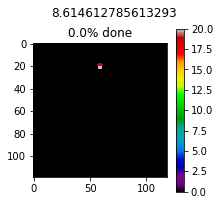

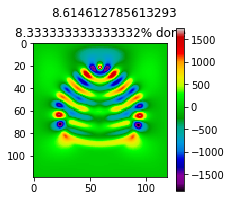

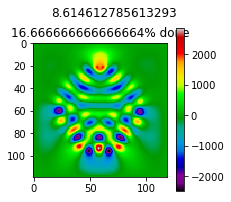

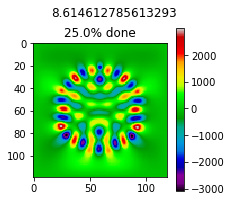

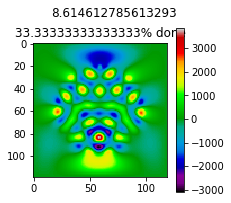

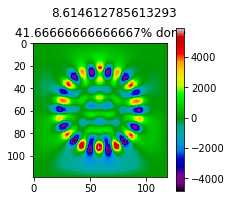

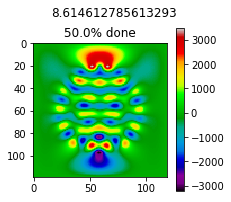

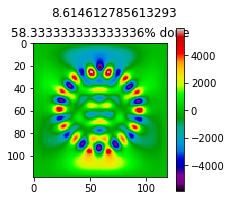

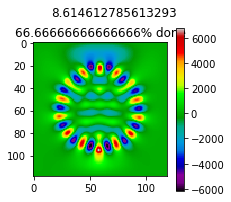

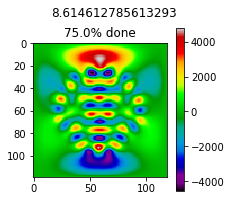

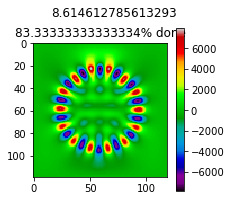

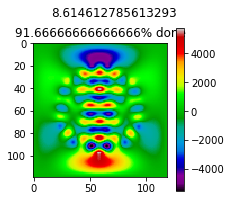

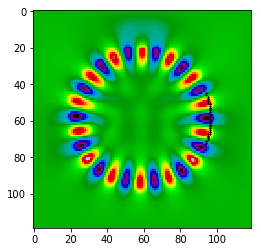

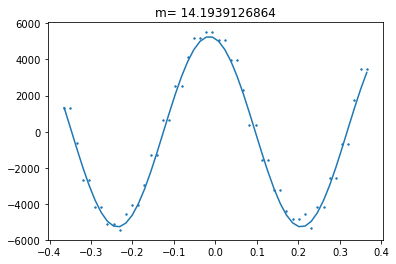

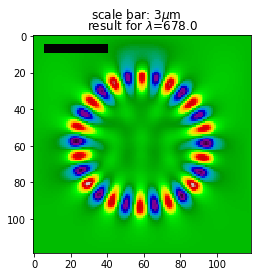

In [42]:
# ================ MAIN PROGRAM ==================
with np.errstate(divide='ignore'):
    np.float64(1.0) / 0.0
    
#----- set up the geometry --------
rmax=5 #size of the whole simulation (micrometer)
radiusLaser=3.3 #cavity radius (micrometer)
n0=3.55 #refractive index inside the cavity
nBack=1 #refractive index outside
nBack2=1.4 #refractive index outside
nBack3=1.5
dimensions=60
#----- some simulation specifics --------
runs=9000
plotFreq=750 #larger plotFreq -> fewer plots
deltaT=0.1 #one timestep (femtoseconds)

fitM=False #boolean whether or not to fit the radial mode number
plotAll=False #boolean whether or not to plot heatmaps throughout simulation
fitM2=True #boolean whether or not to fit the radial mode number
plotAll2=True #boolean whether or not to plot heatmaps throughout simulation


fStart=0.428 #start frequency of the spectrum we are analyzing
fStop=0.46 #end of spetrum
#----- frequencies of interest (units 1000 THz ) --------
sourceFreq=0.3/0.678 #determines the frequency of the driving field and therefore the output field

print('simulating lambda='+str(0.3/(sourceFreq)))
x, y = mesh(rmax, dimensions)
u, u0, n , bc = simple_source(rmax, dimensions, x, y, radiusLaser, n0, nBack)
s0=np.copy(u) #the source is equal to the initial conditions
u2, u02=simulate(deltaT, runs, plotFreq, u, u0, n, s0, sourceFreq, x, y, radiusLaser, dimensions, n0, True, True)
plt.figure()
if True: #adds a scalebar -- WARNING this modifies the data. only run if you don't need the u array anymore
    for i in range(5, 10):
        for j  in range(5, dimensions):
            start=x[5][5]
            if (x[i][j]>start-3)&(x[i][j]<start):
                u2[i][j]=-np.max(np.abs(u2))
plt.title(r'result for $\lambda$='+str(round(3*10**8/(sourceFreq*10**6), 2)))
plt.suptitle(r'scale bar: 3$\mu$m')
plt.imshow(u2, cmap='nipy_spectral')
plt.show()

0.0% done
5.0% done
10.0% done


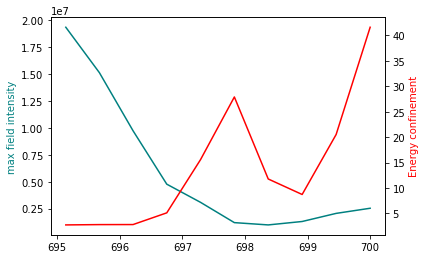

showing best resonance


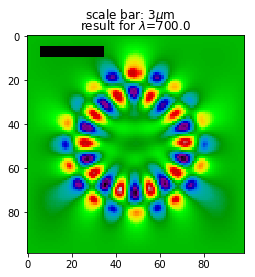

15.0% done
20.0% done


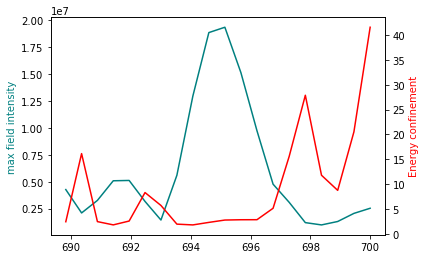

showing best resonance


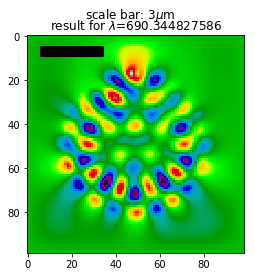

25.0% done
30.0% done


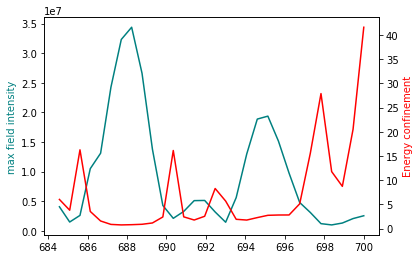

showing best resonance


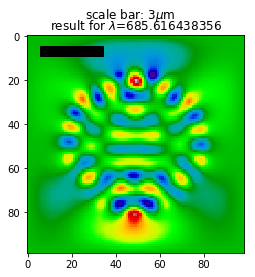

35.0% done
40.0% done


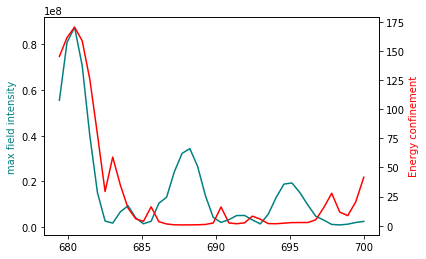

showing best resonance


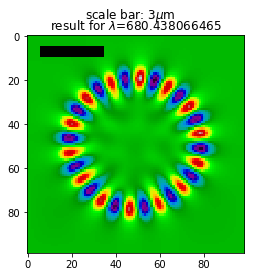

45.0% done
50.0% done


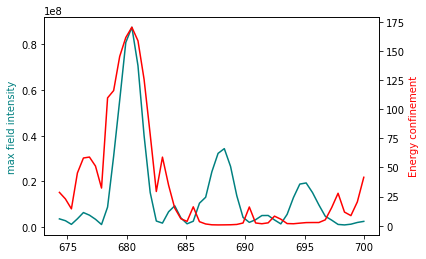

showing best resonance


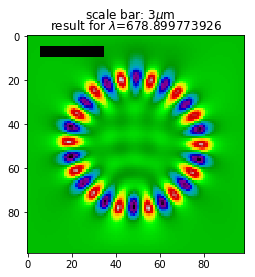

55.00000000000001% done
60.0% done


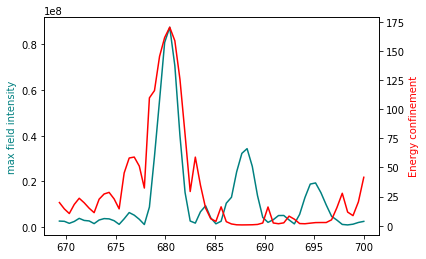

showing best resonance


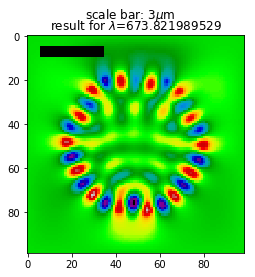

65.0% done
70.0% done


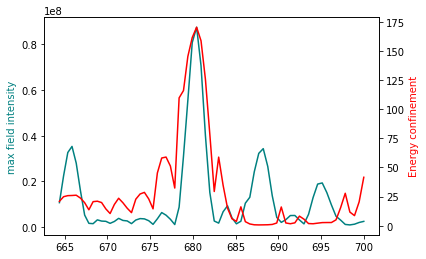

showing best resonance


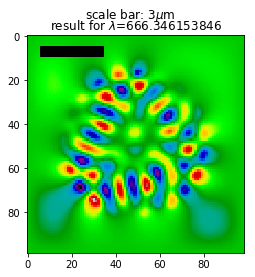

75.0% done
80.0% done


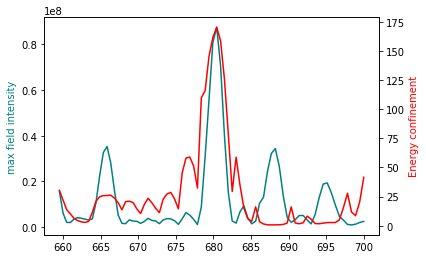

showing best resonance


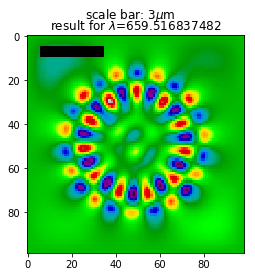

85.0% done
90.0% done


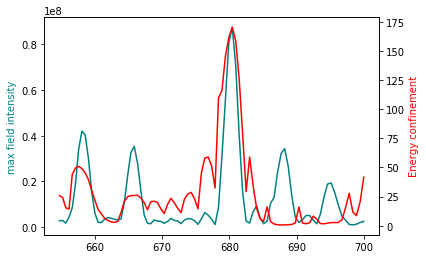

showing best resonance


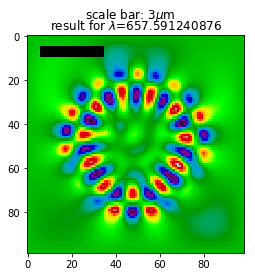

95.0% done


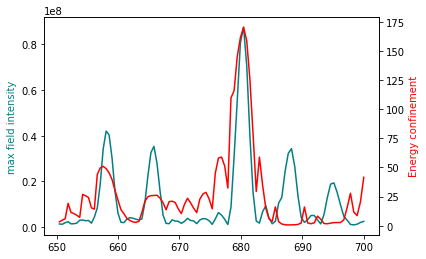

showing best resonance


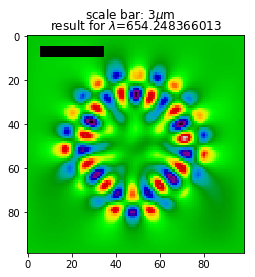

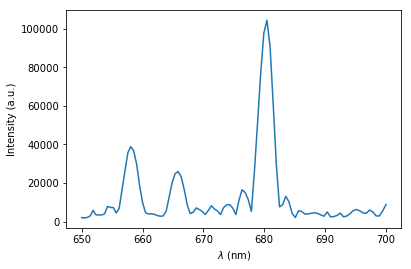

In [55]:
allF=[]
allQ=[]
#application note - for a well defined spectrum, maxLen needs to be very large
#runs for a long time.
E,m=spectral_sweep(0.3/0.7, 0.3/0.65, nBack, allF, allQ, rmax=5, dim=50, radius=3.3, dt=0.2, n0=3.55, maxLen=20000, noWL=100)
plt.figure()
plt.plot(300/np.array(allF), np.array(E)*np.array(allQ))
plt.xlabel(r"$\lambda$ (nm)")
plt.ylabel('Intensity (a.u.)')
plt.show()
